In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
import struct
from softmax import softmax 

# いらないです。これは他の機能との繰り返しである。

# def load_mnist(path, kind='train'):
#     """Load MNIST data from `path`."""
#     labels_path = os.path.join(path,
#                             '%s-labels-idx1-ubyte' % kind)
#     images_path = os.path.join(path,
#                             '%s-images-idx3-ubyte' % kind)

#     # gzip.open() を open() に変更
#     with open(labels_path, 'rb') as lbpath:
#         labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
#                                offset=8)

#     with open(images_path, 'rb') as imgpath:
#         images = np.frombuffer(imgpath.read(), dtype=np.uint8,
#                                offset=16).reshape(len(labels), 784)

#     return images, labels

# def save_to_pickle(data, filename):
#     """Save data to a pickle file."""
#     with open(filename, 'wb') as f:
#         pickle.dump(data, f)

# # データの読み込み
# X_train, y_train = load_mnist('./dataset', kind='train')
# X_test, y_test = load_mnist('./dataset', kind='t10k')

# # pickleファイルに保存
# save_to_pickle((X_train, y_train), 'mnist_train.pkl')
# save_to_pickle((X_test, y_test), 'mnist_test.pkl')

In [2]:
def load_mnist(path='mini-project/hiroka-s-minipro2024/study_dataset', kind='train', normalize=False,one_hot_label=True):
    """MNISTデータセットを読み込む関数

    Args:
        path (str): データセットのファイルが置かれているディレクトリのパス
        kind (str, optional): "train" or "t10k". Defaults to "train".

    Returns:
        tuple: 画像データのNumPy配列, ラベルデータのNumPy配列
    """

    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), rows, cols)

    return images, labels

In [3]:
# page 92, あなたのload_mnistのコードに合わせて変更しました。

#第4章では、one hot encodingが重要である。クロスエントロピー損失関数を使うからだ。


def change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T
import sys, os

x_train, t_train = load_mnist(path='./dataset', kind='train')
x_test, t_test = load_mnist(path='./dataset', kind='t10k')


#reshape to match sample_weights.pkl 
x_train, x_test = x_train.reshape(-1,28*28), x_test.reshape(-1, 28*28)
#one-hot encoding 
t_train, t_test = change_one_hot_label (t_train), change_one_hot_label(t_test)

print(x_train.shape, t_train.shape) # (60000, 784)
print(t_train.shape, t_test.shape) # (60000, 10)



(60000, 784) (60000, 10)
(60000, 10) (10000, 10)


In [4]:
#page 114
# this is the converted code to torch 
import torch 
import torch.nn as nn 
import torch.nn.functional as F

class TwoLayerNet_torch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet_torch, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2= nn.Linear(hidden_size, output_size)

    def forward(self, x):
        a1 = self.fc1(x)
        z1 = torch.sigmoid(a1)
        a2 = self.fc2(z1)
        y = F.softmax(a2, dim=1)
        return y

In [8]:
# page 118, 
# this is the training loop in torch 

#page 114
# this is the converted code to torch 
import torch 
import torch.nn as nn 
import torch.nn.functional as F


train_loss_list = []
# ハイパーパラメータ
iters_num = 100      # please increase this 
batch_size = 100
learning_rate = 0.1
train_size = x_train.shape[0] # added this one for managing batch training 

network = TwoLayerNet_torch(input_size=784, hidden_size=50, output_size=10)

# computations automated by torch
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

for j in range(100):   # this about epoches, which we will see in the next chapters
    correct = 0
    total = 0
    for _ in range(iters_num):
        # ミニバッチの取得
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        #change from numpy to tensor to work with torch libary 
        x_batch = torch.from_numpy(x_batch).to(torch.float32)
        t_batch = torch.from_numpy(t_batch).to(torch.float32)

        outputs = network(x_batch)
        loss = F.cross_entropy(outputs, t_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss)

        #lets calculate accuracy as well 
        # Accumulate loss and accuracy
        _, predicted = torch.max(outputs, 1)
        _, true = torch.max(t_batch,1)
        correct += (predicted == true).sum().item()
        total += true.size(0)
    print("epoch:",j,"--------->", "loss:", loss, "accuracy:", correct/total)



epoch: 0 ---------> loss: tensor(2.1584, grad_fn=<DivBackward1>) accuracy: 0.4098
epoch: 1 ---------> loss: tensor(2.0541, grad_fn=<DivBackward1>) accuracy: 0.4655
epoch: 2 ---------> loss: tensor(1.9407, grad_fn=<DivBackward1>) accuracy: 0.5356
epoch: 3 ---------> loss: tensor(1.8611, grad_fn=<DivBackward1>) accuracy: 0.6394
epoch: 4 ---------> loss: tensor(1.8494, grad_fn=<DivBackward1>) accuracy: 0.6708
epoch: 5 ---------> loss: tensor(1.9002, grad_fn=<DivBackward1>) accuracy: 0.6863
epoch: 6 ---------> loss: tensor(1.8195, grad_fn=<DivBackward1>) accuracy: 0.6858
epoch: 7 ---------> loss: tensor(1.7843, grad_fn=<DivBackward1>) accuracy: 0.7036
epoch: 8 ---------> loss: tensor(1.7888, grad_fn=<DivBackward1>) accuracy: 0.7062
epoch: 9 ---------> loss: tensor(1.8068, grad_fn=<DivBackward1>) accuracy: 0.6988
epoch: 10 ---------> loss: tensor(1.8256, grad_fn=<DivBackward1>) accuracy: 0.7
epoch: 11 ---------> loss: tensor(1.8010, grad_fn=<DivBackward1>) accuracy: 0.7126
epoch: 12 -------

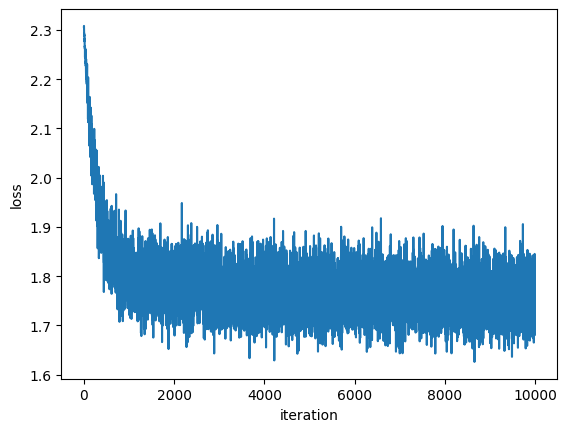

In [10]:
#draw the loss graphs at page 119
import matplotlib.pyplot as plt 
train_loss_list = np.array([t.item() for t in train_loss_list])


plt.plot(range(len(train_loss_list)), train_loss_list)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.show()